# Changing laplacians

In [1]:
import os
import sys
#import time
import numpy as np

# -------------Torch-------------------
import torch
from torch.utils.data import DataLoader

# -------------Graph-------------------
import dgl
import networkx as nx
import matplotlib.pyplot as plt

from utils import set_device
from laplacian import normalized_laplacian

sys.path.insert(0, "lib/")
%load_ext autoreload
%autoreload 2

# MNIST

In [2]:
# Downloads the dataset if not found locally
from Dataset import check_mnist_dataset_exists, datasampler, MNISTDataset
_ = check_mnist_dataset_exists()

train_data, train_labels, test_data, test_labels = datasampler(
    nb_selected_train_data=640, nb_selected_test_data=512
)

testset = MNISTDataset(test_data, test_labels)

## Convolution layer and classifier


In [3]:
from model import Classifier, SanityCheck, SmallCheb

def collate(samples):
    # The input `samples` is a list of pairs
    #  (graph, label, signal).
    graphs, labels, signals = map(list, zip(*samples))
    batched_graph = dgl.batch(graphs)
    return batched_graph, torch.tensor(labels),  torch.stack(signals).view(-1)



# Model definition for training

In [4]:
# model_parameters
in_features = 1
first_conv_out = 32
second_conv_out = 50
hidden_layer_classifier = 512
k = 10
n_classes = testset.num_classes

net = Classifier(
    in_features, first_conv_out, second_conv_out, hidden_layer_classifier, n_classes, k
)

print(net)
if torch.cuda.is_available():
    net.to(device)

Classifier(
  (layers): ModuleList(
    (0): Chebyconv(
      (apply_mod): NodeApplyModule(
        (linear): Linear(in_features=10, out_features=32, bias=True)
      )
    )
    (1): Chebyconv(
      (apply_mod): NodeApplyModule(
        (linear): Linear(in_features=320, out_features=50, bias=True)
      )
    )
  )
  (classify): Sequential(
    (0): Linear(in_features=39200, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [5]:
# LOAD MODEL

from utils import load_model
net.load_state_dict(load_model('Model_6000_20ep'))

<All keys matched successfully>

# Test

In [6]:
import sklearn
from sklearn.metrics import classification_report


def test_func(data_loader):
    net.eval()
    probs_Y = torch.Tensor()
    test_Y = torch.Tensor().int()
    for iter, (bg, label, signal) in enumerate(data_loader):
        if iter == 0:
            L = normalized_laplacian(bg)
        probs_Y = torch.cat((probs_Y, torch.softmax(net(bg, signal, L), 1)), 0)
        test_Y = torch.cat((test_Y, label.int()),0)

    sampled_Y = torch.multinomial(probs_Y, 1)
    argmax_Y = torch.max(probs_Y, 1)[1].view(-1, 1)
    return sklearn.metrics.classification_report(test_Y, argmax_Y, digits=4)

## Original lattice

/Users/axel/miniconda3/envs/DGL/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


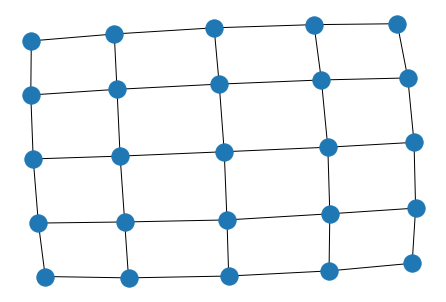

In [28]:
from graphs import regular_2D_lattice

g = regular_2D_lattice(5)
pos=nx.spring_layout(g.to_networkx().to_undirected())
nx.draw(g.to_networkx().to_undirected(),pos)

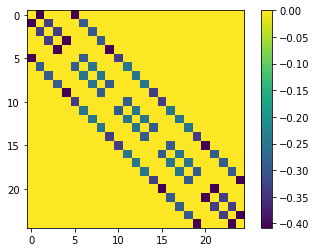

In [29]:
from ninja import Gspyplot, GeigplotH, GeigplotL

L = Gspyplot(g)

In [30]:
L.to_dense()

tensor([[ 2.2204e-16, -4.0825e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         -4.0825e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [-4.0825e-01,  2.2204e-16, -3.3333e-01,  0.0000e+00,  0.0000e+00,
          0.0000e+00, -2.8868e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00, -3.3333e-01,  2.2204e-16, -3.3333e-01,  0.0000e+00,
          0.0000e+00,  0.0000e+00, -2.8868e-01,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  

Largest eigenvalue: 2.0000000000000013
Smallest eigenvalue: 2.220446049250313e-16


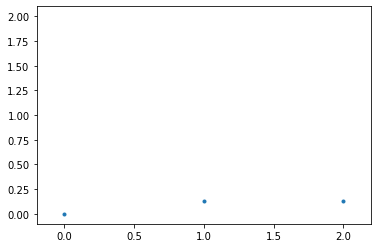

In [48]:
GeigplotL(g)

In [10]:
# Define a test function
data_loader_test = DataLoader(testset, batch_size=256,
                              shuffle=False, collate_fn=collate)
print(test_func(data_loader_test))

              precision    recall  f1-score   support

           0     0.9130    1.0000    0.9545        42
           1     1.0000    1.0000    1.0000        69
           2     0.9636    0.9464    0.9550        56
           3     1.0000    0.9583    0.9787        48
           4     0.9636    0.9464    0.9550        56
           5     0.9800    0.9423    0.9608        52
           6     0.9762    0.9318    0.9535        44
           7     0.9608    0.9800    0.9703        50
           8     0.8864    0.9750    0.9286        40
           9     0.9630    0.9455    0.9541        55

    accuracy                         0.9629       512
   macro avg     0.9607    0.9626    0.9610       512
weighted avg     0.9641    0.9629    0.9630       512



## Other lattice

/Users/axel/miniconda3/envs/DGL/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


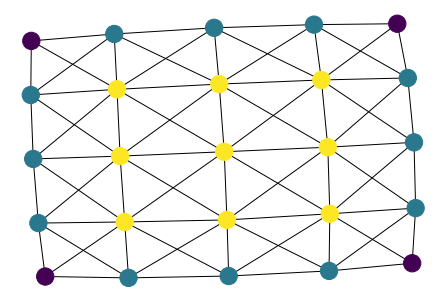

In [32]:
from graphs import regular_2D_lattice_8_neighbors

g2 = regular_2D_lattice_8_neighbors(5)
nx.draw(g2.to_networkx().to_undirected(),pos,node_color=np.array(g2.to_networkx().to_undirected().degree())[:,1],cmap=plt.cm.viridis)

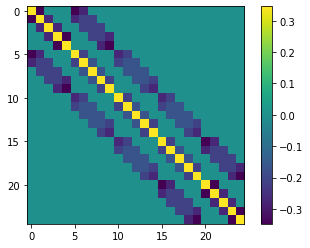

In [33]:
L2 = Gspyplot(g2)

In [34]:
L2.to_dense()

tensor([[ 0.3461, -0.3476,  0.0000,  0.0000,  0.0000, -0.3476, -0.2748,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000],
        [-0.3476,  0.3461, -0.2692,  0.0000,  0.0000, -0.2692, -0.2128, -0.2128,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000],
        [ 0.0000, -0.2692,  0.3461, -0.2692,  0.0000,  0.0000, -0.2128, -0.2128,
         -0.2128,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000],
        [ 0.0000,  0.0000, -0.2692,  0.3461, -0.3476,  0.0000,  0.0000, -0.2128,
         -0.2128, -0.2692,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000

Largest eigenvalue: 1.4858041353534703
Smallest eigenvalue: 5.551115123125783e-17


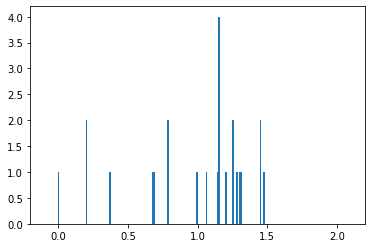

In [35]:
from ninja import GeigplotH
GeigplotH(g2)

Norm 1 distance: tensor(28.2855) 
Norm 2 distance: tensor(2.5502)


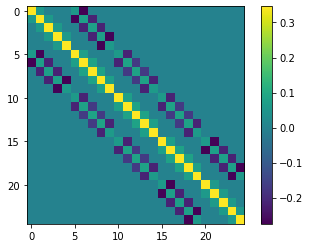

In [36]:
res = L2-L
print('Norm 1 distance:', torch.norm(res, p=1),
      '\nNorm 2 distance:', torch.norm(res, p=2))
plt.imshow(res.to_dense(),cmap='viridis')
plt.colorbar()

In [37]:
testset_2 = MNISTDataset(test_data, test_labels, lattice_type=1)

# Define a test function
data_loader_test = DataLoader(testset_2, batch_size=256,
                              shuffle=False, collate_fn=collate)
print(test_func(data_loader_test))

              precision    recall  f1-score   support

           0     0.8837    0.9048    0.8941        42
           1     1.0000    0.7971    0.8871        69
           2     0.9787    0.8214    0.8932        56
           3     0.7321    0.8542    0.7885        48
           4     0.8958    0.7679    0.8269        56
           5     0.8250    0.6346    0.7174        52
           6     0.9302    0.9091    0.9195        44
           7     0.9091    0.2000    0.3279        50
           8     0.5741    0.7750    0.6596        40
           9     0.4522    0.9455    0.6118        55

    accuracy                         0.7598       512
   macro avg     0.8181    0.7609    0.7526       512
weighted avg     0.8269    0.7598    0.7561       512



## Random supression

/Users/axel/miniconda3/envs/DGL/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


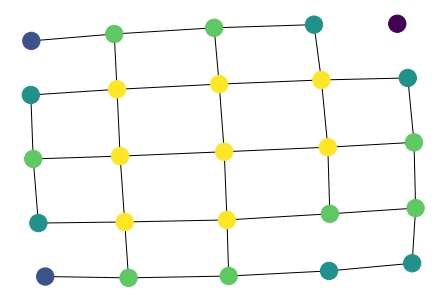

In [38]:
from graphs import random_edge_suppression

g3 = random_edge_suppression(5,5)
nx.draw(g3.to_networkx().to_undirected(), pos, node_color=np.array(
    g3.to_networkx().to_undirected().degree())[:, 1], cmap=plt.cm.viridis)

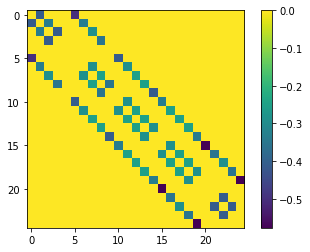

In [39]:
L3 = Gspyplot(g3)

In [40]:
L3.to_dense()

tensor([[-2.2204e-15, -4.0825e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         -5.0000e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [-4.0825e-01, -2.2204e-15, -3.3333e-01,  0.0000e+00,  0.0000e+00,
          0.0000e+00, -3.3333e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00, -3.3333e-01, -2.2204e-15, -4.0825e-01,  0.0000e+00,
          0.0000e+00,  0.0000e+00, -2.8868e-01,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  

Norm 1 distance: tensor(6.2154) 
Norm 2 distance: tensor(1.3157)


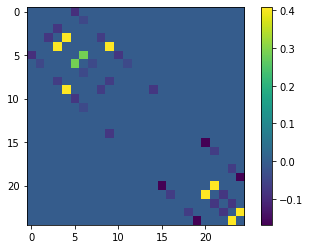

In [41]:
res = L3-L
print('Norm 1 distance:', torch.norm(res, p=1),
      '\nNorm 2 distance:', torch.norm(res, p=2))
plt.imshow(res.to_dense(), cmap='viridis')
plt.colorbar()

In [20]:
testset_3 = MNISTDataset(test_data, test_labels, lattice_type=2)

# Define a test function
data_loader_test = DataLoader(testset_3, batch_size=256,
                              shuffle=False, collate_fn=collate)
print(test_func(data_loader_test))

              precision    recall  f1-score   support

           0     0.9111    0.9762    0.9425        42
           1     1.0000    1.0000    1.0000        69
           2     0.9636    0.9464    0.9550        56
           3     1.0000    0.9375    0.9677        48
           4     0.9643    0.9643    0.9643        56
           5     0.9600    0.9231    0.9412        52
           6     0.9767    0.9545    0.9655        44
           7     0.9245    0.9800    0.9515        50
           8     0.8837    0.9500    0.9157        40
           9     0.9623    0.9273    0.9444        55

    accuracy                         0.9570       512
   macro avg     0.9546    0.9559    0.9548       512
weighted avg     0.9583    0.9570    0.9572       512



# Model trained on the 8 lattice

In [18]:
# model_parameters
in_features = 1
first_conv_out = 32
second_conv_out = 50
hidden_layer_classifier = 512
k = 10
n_classes = testset.num_classes

net = Classifier(
    in_features, first_conv_out, second_conv_out, hidden_layer_classifier, n_classes, k
)

print(net)
if torch.cuda.is_available():
    net.to(device)

Classifier(
  (layers): ModuleList(
    (0): Chebyconv(
      (apply_mod): NodeApplyModule(
        (linear): Linear(in_features=10, out_features=32, bias=True)
      )
    )
    (1): Chebyconv(
      (apply_mod): NodeApplyModule(
        (linear): Linear(in_features=320, out_features=50, bias=True)
      )
    )
  )
  (classify): Sequential(
    (0): Linear(in_features=39200, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [19]:
# LOAD MODEL trained on 8 neighbors

from utils import load_model
net.load_state_dict(load_model('Model_6000_20ep_8_lattice'))

<All keys matched successfully>

## Original lattice

In [20]:
testset = MNISTDataset(test_data, test_labels, lattice_type=0)

# Define a test function
data_loader_test = DataLoader(testset, batch_size=256,
                              shuffle=False, collate_fn=collate)
print(test_func(data_loader_test))

              precision    recall  f1-score   support

           0     0.9167    0.5238    0.6667        42
           1     0.8961    1.0000    0.9452        69
           2     0.6623    0.9107    0.7669        56
           3     0.8636    0.3958    0.5429        48
           4     0.9655    0.5000    0.6588        56
           5     0.3770    0.8846    0.5287        52
           6     0.9130    0.4773    0.6269        44
           7     0.3643    0.9400    0.5251        50
           8     1.0000    0.1000    0.1818        40
           9     0.8000    0.0727    0.1333        55

    accuracy                         0.6074       512
   macro avg     0.7759    0.5805    0.5576       512
weighted avg     0.7714    0.6074    0.5763       512



## 8 lattice

In [21]:
testset_2 = MNISTDataset(test_data, test_labels, lattice_type=1)

# Define a test function
data_loader_test = DataLoader(testset_2, batch_size=256,
                              shuffle=False, collate_fn=collate)
print(test_func(data_loader_test))

              precision    recall  f1-score   support

           0     0.9130    1.0000    0.9545        42
           1     1.0000    1.0000    1.0000        69
           2     0.9818    0.9643    0.9730        56
           3     0.9787    0.9583    0.9684        48
           4     0.9474    0.9643    0.9558        56
           5     0.9423    0.9423    0.9423        52
           6     0.9762    0.9318    0.9535        44
           7     0.9412    0.9600    0.9505        50
           8     0.9512    0.9750    0.9630        40
           9     0.9615    0.9091    0.9346        55

    accuracy                         0.9609       512
   macro avg     0.9593    0.9605    0.9596       512
weighted avg     0.9615    0.9609    0.9609       512



## Random suppresion

In [22]:
testset_3 = MNISTDataset(test_data, test_labels, lattice_type=2)

# Define a test function
data_loader_test = DataLoader(testset_3, batch_size=256,
                              shuffle=False, collate_fn=collate)
print(test_func(data_loader_test))

              precision    recall  f1-score   support

           0     0.9130    0.5000    0.6462        42
           1     0.8767    0.9275    0.9014        69
           2     0.6250    0.8929    0.7353        56
           3     0.8182    0.3750    0.5143        48
           4     0.9643    0.4821    0.6429        56
           5     0.3651    0.8846    0.5169        52
           6     0.9444    0.3864    0.5484        44
           7     0.3561    0.9400    0.5165        50
           8     0.7500    0.0750    0.1364        40
           9     0.8333    0.0909    0.1639        55

    accuracy                         0.5820       512
   macro avg     0.7446    0.5554    0.5322       512
weighted avg     0.7447    0.5820    0.5518       512



# Trying to know where the performance breaks down

In [23]:
# Using the 4-neighbors trained model

# model_parameters
in_features = 1
first_conv_out = 32
second_conv_out = 50
hidden_layer_classifier = 512
k = 10
n_classes = testset.num_classes

net = Classifier(
    in_features, first_conv_out, second_conv_out, hidden_layer_classifier, n_classes, k
)

print(net)
if torch.cuda.is_available():
    net.to(device)
    
# LOAD MODEL

from utils import load_model
net.load_state_dict(load_model('Model_6000_20ep'))

Classifier(
  (layers): ModuleList(
    (0): Chebyconv(
      (apply_mod): NodeApplyModule(
        (linear): Linear(in_features=10, out_features=32, bias=True)
      )
    )
    (1): Chebyconv(
      (apply_mod): NodeApplyModule(
        (linear): Linear(in_features=320, out_features=50, bias=True)
      )
    )
  )
  (classify): Sequential(
    (0): Linear(in_features=39200, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=512, out_features=10, bias=True)
  )
)


<All keys matched successfully>

In [25]:
def test_func(data_loader):
    net.eval()
    probs_Y = torch.Tensor()
    test_Y = torch.Tensor().int()
    for iter, (bg, label, signal) in enumerate(data_loader):
        if iter == 0:
            L = normalized_laplacian(bg)
        probs_Y = torch.cat((probs_Y, torch.softmax(net(bg, signal, L), 1)), 0)
        test_Y = torch.cat((test_Y, label.int()),0)

    sampled_Y = torch.multinomial(probs_Y, 1)
    argmax_Y = torch.max(probs_Y, 1)[1].view(-1, 1)
    return sklearn.metrics.classification_report(test_Y, argmax_Y, digits=4, output_dict=True)

In [26]:
repz = []

for i in range(0,800,50):
    report = []
    for j in range(4):
        testset = MNISTDataset(test_data, test_labels, lattice_type=2, nb_removal=i)

        # Define a test function
        data_loader_test = DataLoader(testset, batch_size=256,
                                      shuffle=False, collate_fn=collate)
        
        report.append(test_func(data_loader_test)['accuracy'])
        
    repz.append(report)

In [29]:
import pandas as pd
df = pd.DataFrame(repz)

df['mean'] = df.mean(1)
df['std'] = df.std(1)
print(df)

           0         1         2         3      mean       std
0   0.962891  0.962891  0.962891  0.962891  0.962891  0.000000
1   0.964844  0.962891  0.960938  0.955078  0.960938  0.003654
2   0.962891  0.962891  0.957031  0.958984  0.960449  0.002537
3   0.931641  0.962891  0.957031  0.939453  0.947754  0.012686
4   0.923828  0.933594  0.943359  0.937500  0.934570  0.007109
5   0.898438  0.906250  0.935547  0.873047  0.903320  0.022290
6   0.908203  0.894531  0.861328  0.876953  0.885254  0.017707
7   0.826172  0.869141  0.830078  0.847656  0.843262  0.016992
8   0.863281  0.750000  0.746094  0.849609  0.802246  0.054432
9   0.734375  0.759766  0.664062  0.771484  0.732422  0.041684
10  0.642578  0.558594  0.732422  0.707031  0.660156  0.067163
11  0.613281  0.662109  0.539062  0.703125  0.629395  0.061086
12  0.626953  0.562500  0.597656  0.509766  0.574219  0.043651
13  0.587891  0.417969  0.533203  0.455078  0.498535  0.066268
14  0.365234  0.396484  0.453125  0.457031  0.417969  0

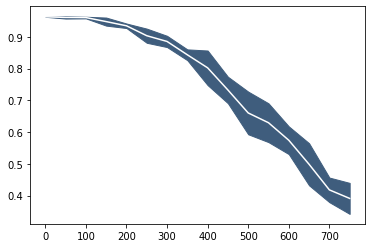

In [51]:
x = range(0,800,50)
plt.plot(x, df['mean'], color='white')
plt.fill_between(x, df['mean'] - df['std'],
                 df['mean'] + df['std'], color="#3F5D7D")
plt.title('Accuracy over number of removed edges')

In [43]:
print('the maximum removal rate is',750*100/3024,'% of all edges')

the maximum removal rate is 24.8015873015873 % of all edges
